# Customer Segmentation Dataset

https://www.kaggle.com/datasets/yasserh/customer-segmentation-dataset/code

## Import Libraries

In [18]:
import warnings
warnings.filterwarnings('ignore')

import math
import random
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OrdinalEncoder,
    PowerTransformer,
    FunctionTransformer
)

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

seed = 42
random.seed(seed)
np.random.seed(seed)

In [19]:
# # Import dataset from kaggle
# import os
# os.environ['KAGGLE_USERNAME'] = "rezafsihab1" # username from the json file
# os.environ['KAGGLE_KEY'] = "5cf1e0fe49d43fd729d80e50a8f559c3" # key from the json file

# # Link dataset
# !kaggle datasets download -d yasserh/customer-segmentation-dataset # api copied from kaggle
# # link: https://www.kaggle.com/datasets/yasserh/customer-segmentation-dataset/code

# # Unzip file
# !unzip /content/customer-segmentation-dataset.zip

## Data Understanding

In [20]:
# df = pd.read_excel('/content/Online Retail.xlsx')
df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [22]:
# Cek missing value pada masing-masing kolom
info_df = pd.DataFrame(df.isnull().sum(), columns=['#missing'])
info_df['% missing'] = (info_df['#missing'] / len(df)) * 100
info_df['# nunique'] = df.nunique()
info_df['dtype'] = df.dtypes
info_df['Jumlah baris'] = df.shape[0]
info_df['Jumlah kolom'] = df.shape[1]
shorting_info_df = info_df.sort_values(by='#missing', ascending=False)
shorting_info_df

,#missing,% missing,# nunique,dtype,Jumlah baris,Jumlah kolom
CustomerID,135080,24.926694,4372,float64,541909,8
Description,1454,0.268311,4223,object,541909,8
InvoiceNo,0,0.000000,25900,object,541909,8
StockCode,0,0.000000,4070,object,541909,8
Quantity,0,0.000000,722,int64,541909,8
InvoiceDate,0,0.000000,23260,datetime64[ns],541909,8
UnitPrice,0,0.000000,1630,float64,541909,8
Country,0,0.000000,38,object,541909,8


In [23]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## Data Preprocessing

### Drop missing values

In [24]:
# membuat tabel total persentasi missing value per featurenya
total_data = len(df)
data_nan = df.isna().sum().reset_index()
data_nan.columns = ['feature','missing_value']
data_nan['total_data'] = total_data
data_nan['percentage'] = round((data_nan['missing_value']/total_data)*100,3)
data_nan = data_nan.sort_values('percentage', ascending=False).reset_index(drop=True)
data_nan = data_nan[data_nan['percentage']>0]
data_nan

,feature,missing_value,total_data,percentage
0,CustomerID,135080,541909,24.927
1,Description,1454,541909,0.268


There are only two columns containing missing values: Description and CustomerID. Considering the uniqueness nature of CustomerID, it does not make sense to fill the missing values with another value, so we will just drop them. The remaining missing values in the Description column will be replaced with an empty string, so we can keep the rest of the information of those rows.

It is important to observe that after the removal of the missing values, a lot of data still remains in the dataset, so probably we won't have information loss problem.

In [25]:
df1 = df.copy()
df.drop(df[df["CustomerID"].isnull()].index, axis=0, inplace=True)
df["Description"] = df["Description"].fillna("")
df.isnull().sum().sum()

0

In [26]:
df.shape

(406829, 8)

In [27]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Duplicates Value

In [28]:
df.duplicated().sum()

5225

In [29]:
# dropping duplicate values
df.drop_duplicates(inplace=True)

In [30]:
print(df.duplicated().sum())
print(df.shape)

0
(401604, 8)


### Treating Canceled Invoices

In [31]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


* Check point

In [36]:
df1 = df.copy()

In [38]:
df = df1
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Giving a deeper look into the values of _Quantity_, we can see some negative values. For the purpose of our analysis, it doesn't make sense to keep canceled invoices data in the dataset, so we will remove them along with their positive counterparts.

In [39]:
size_before = len(df)
neg_quantity = df[df["Quantity"] < 0][["CustomerID", "StockCode", "Quantity"]].sort_values("Quantity")
print(f"Negative Quantity: {len(neg_quantity)}")

filtered = df[df["CustomerID"].isin(neg_quantity["CustomerID"])]
filtered = filtered[filtered["StockCode"].isin(neg_quantity["StockCode"])]

pos_counters = []
for idx, series in neg_quantity.iterrows():
    customer = series["CustomerID"]
    code = series["StockCode"]
    quantity = -1 * series["Quantity"]
    counterpart = filtered[(filtered["CustomerID"] == customer) & (filtered["StockCode"] == code) & (filtered["Quantity"] == quantity)]
    pos_counters.extend(counterpart.index.to_list())

to_drop = neg_quantity.index.to_list() + pos_counters
df.drop(to_drop, axis=0, inplace=True)
print(f"Removed {size_before - len(df)} rows from the dataset")

Negative Quantity: 8872
Removed 14349 rows from the dataset


In [40]:
(df["Quantity"] <= 0).sum()

0

The dataset contains some rows where the value of UnitPrice is 0, so we will remove them.

In [ ]:
df.drop(df[df["UnitPrice"] == 0].index, axis=0, inplace=True)

## Feature Engineering and Preprocessing

### Feature Extraction

In [ ]:
# extracting time related features from InvoiceDate

df["InvoiceDateDay"] = df["InvoiceDate"].dt.date
df["InvoiceDateTime"] = df["InvoiceDate"].dt.time
df["InvoiceYear"] = df["InvoiceDate"].dt.year
df["InvoiceMonth"] = df["InvoiceDate"].dt.month
df["InvoiceMonthName"] = df["InvoiceDate"].dt.month_name()
df["InvoiceDay"] = df["InvoiceDate"].dt.day
df["InvoiceDayName"] = df["InvoiceDate"].dt.day_name()
df["InvoiceDayOfWeek"] = df["InvoiceDate"].dt.day_of_week
df["InvoiceWeekOfYear"] = df["InvoiceDate"].dt.weekofyear
df["InvoiceHour"] = df["InvoiceDate"].dt.hour

df["TotalValue"] = df["Quantity"] * df["UnitPrice"]

### RFM Analysis

In the customer segmentation part of this project we will use RFM analysis to group the customers into meaningfull groups with similar purchasing behavior. RFM stands for Recency, Frequency and Monetary Value, the three key metrics used to segment customers.

In order to perform this analysis, we need to build a new DataFrame with a single row per customer containing the metrics cited above.

In [ ]:
ref_date = df["InvoiceDateDay"].max() + timedelta(days=1)

df_customers = df.groupby("CustomerID").agg({
    "InvoiceDateDay": lambda x : (ref_date - x.max()).days,
    "InvoiceNo": "count",
    "TotalValue": "sum"
}).rename(columns={
    "InvoiceDateDay": "Recency",
    "InvoiceNo": "Frequency",
    "TotalValue": "Monetary"
})

In [ ]:
df_customers.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,3,182,4310.00
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40
12352.0,37,67,1405.28


### Removing Outliers

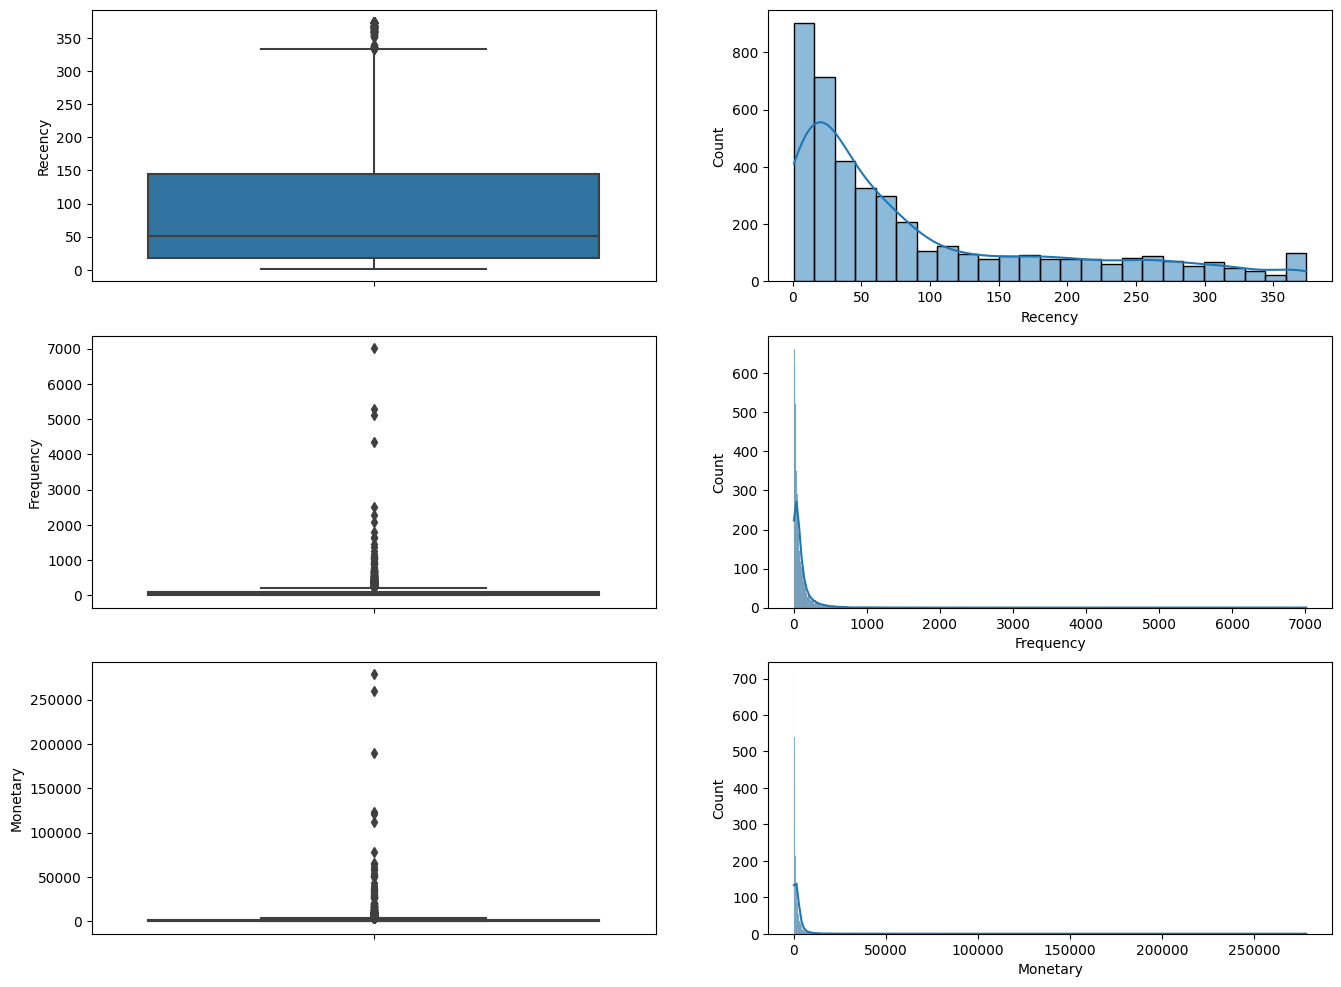

In [ ]:
n_cols = len(df_customers.columns)
fig, axes = plt.subplots(n_cols, 2, figsize=(16, n_cols * 4))

for i, col in enumerate(df_customers.columns):
    sns.boxplot(data=df_customers, y=col, ax=axes[i][0])
    sns.histplot(data=df_customers, x=col, kde=True, ax=axes[i][1])

fig.show()

As we can see, because of the presence of **outliers** in our dataset, the data analysis becomes very difficult. Also, **outliers** can decrease our clustering models performance, adding some noisy behavior to our data, _biasing_ the estimated clusters. In order to prevent these problems, we will remove some of them through the IQR technique.

In [ ]:
def remove_outliers(df, col, threshold=1.5):
    Q1 = np.quantile(df[col], .25)
    Q3 = np.quantile(df[col], .75)
    IQR = Q3 - Q1
    df.drop(df[(df[col] < (Q1 - threshold * IQR)) | (df[col] > (Q3 + threshold * IQR))].index, axis=0, inplace=True)
    
    return df

for col in df_customers.columns:
    size_before = len(df_customers)
    df_customers = remove_outliers(df_customers, col)
    print(f"Removed {size_before - len(df_customers)} outliers from {col}")

Removed 140 outliers from Recency
Removed 363 outliers from Frequency
Removed 313 outliers from Monetary


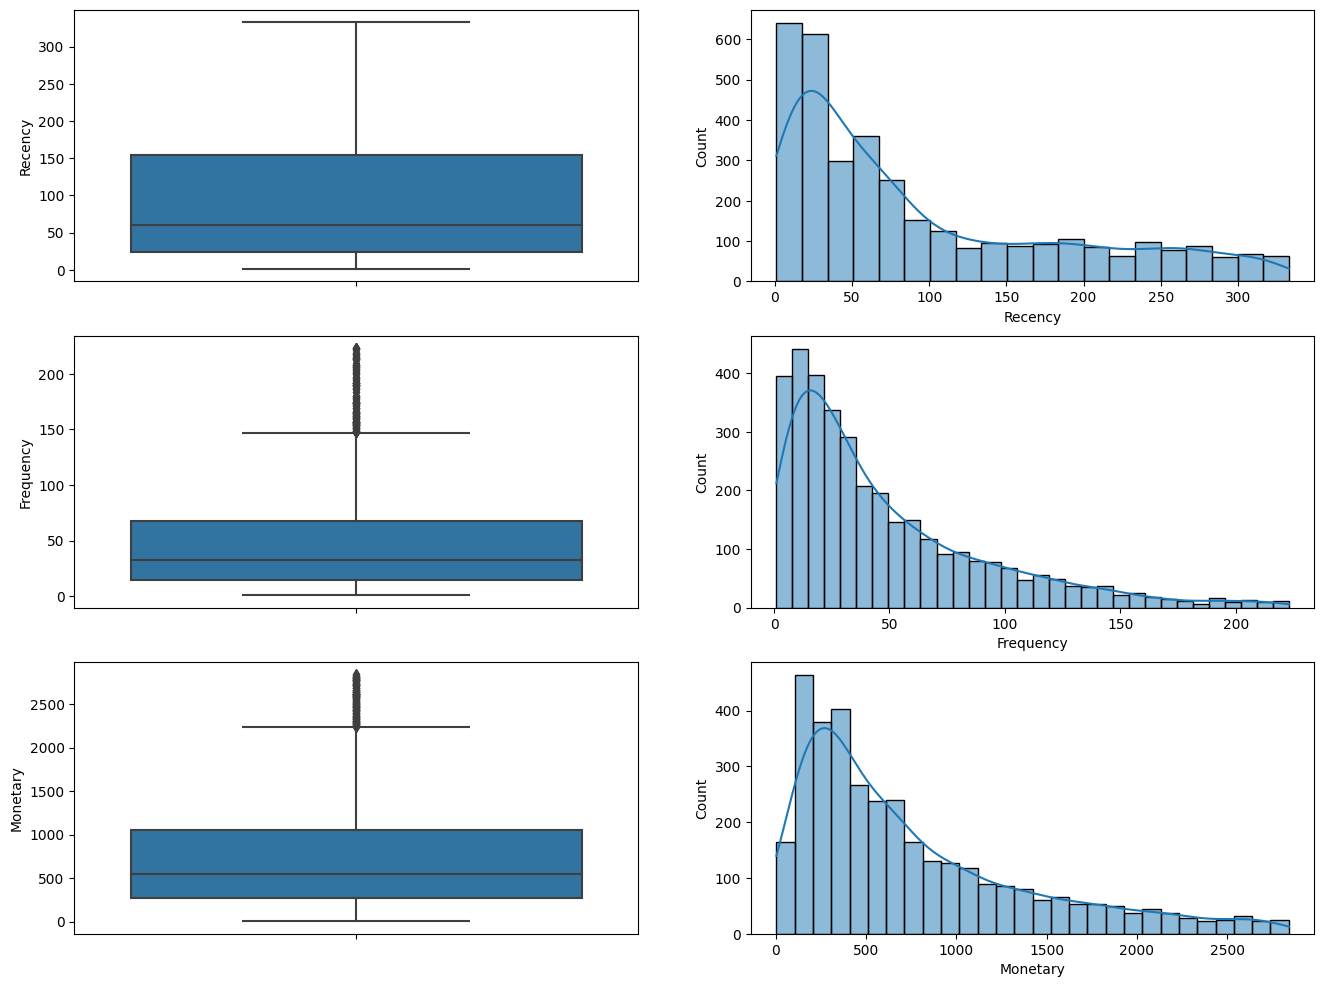

In [ ]:
# Re-Check Visualisation
n_cols = len(df_customers.columns)
fig, axes = plt.subplots(n_cols, 2, figsize=(16, n_cols * 4))

for i, col in enumerate(df_customers.columns):
    sns.boxplot(data=df_customers, y=col, ax=axes[i][0])
    sns.histplot(data=df_customers, x=col, kde=True, ax=axes[i][1])

fig.show()

Our visualization and understanding about the data got much better now. So we can go further to the exploratory data analysis phase.

In [ ]:
df_customers.head()

,Recency,Frequency,Monetary
CustomerID,,,
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40
12352.0,37,67,1405.28
12353.0,205,4,89.00


## Modeling and evaluation with RFM data

### Feature Selection

In [ ]:
feat = ['Recency','Frequency','Monetary']
dataset = df_customers[feat].copy()

### Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(dataset)

In [ ]:
feats = list(dataset)
new_df = pd.DataFrame(data = X_std, columns = feats)
new_df.head()

,Recency,Frequency,Monetary
0,-0.212209,-0.383157,1.600019
1,-0.835473,0.554114,1.538898
2,2.357390,-0.695580,-0.652687
3,-0.638653,0.420219,0.996419
4,1.198337,-0.985688,-1.030591


### Reduction with TSNE (RFM)

In [ ]:
from sklearn.manifold import TSNE

Xtsne = TSNE(n_components=2).fit_transform(X_std)
dftsne = pd.DataFrame(Xtsne)
dftsne.columns = ['x1','x2']
dftsne.head()

,x1,x2
0,16.743134,13.198086
1,31.603968,19.764206
2,-12.048372,47.722733
3,29.312759,5.438109
4,-49.053398,25.206444


### Best K

<Axes: >

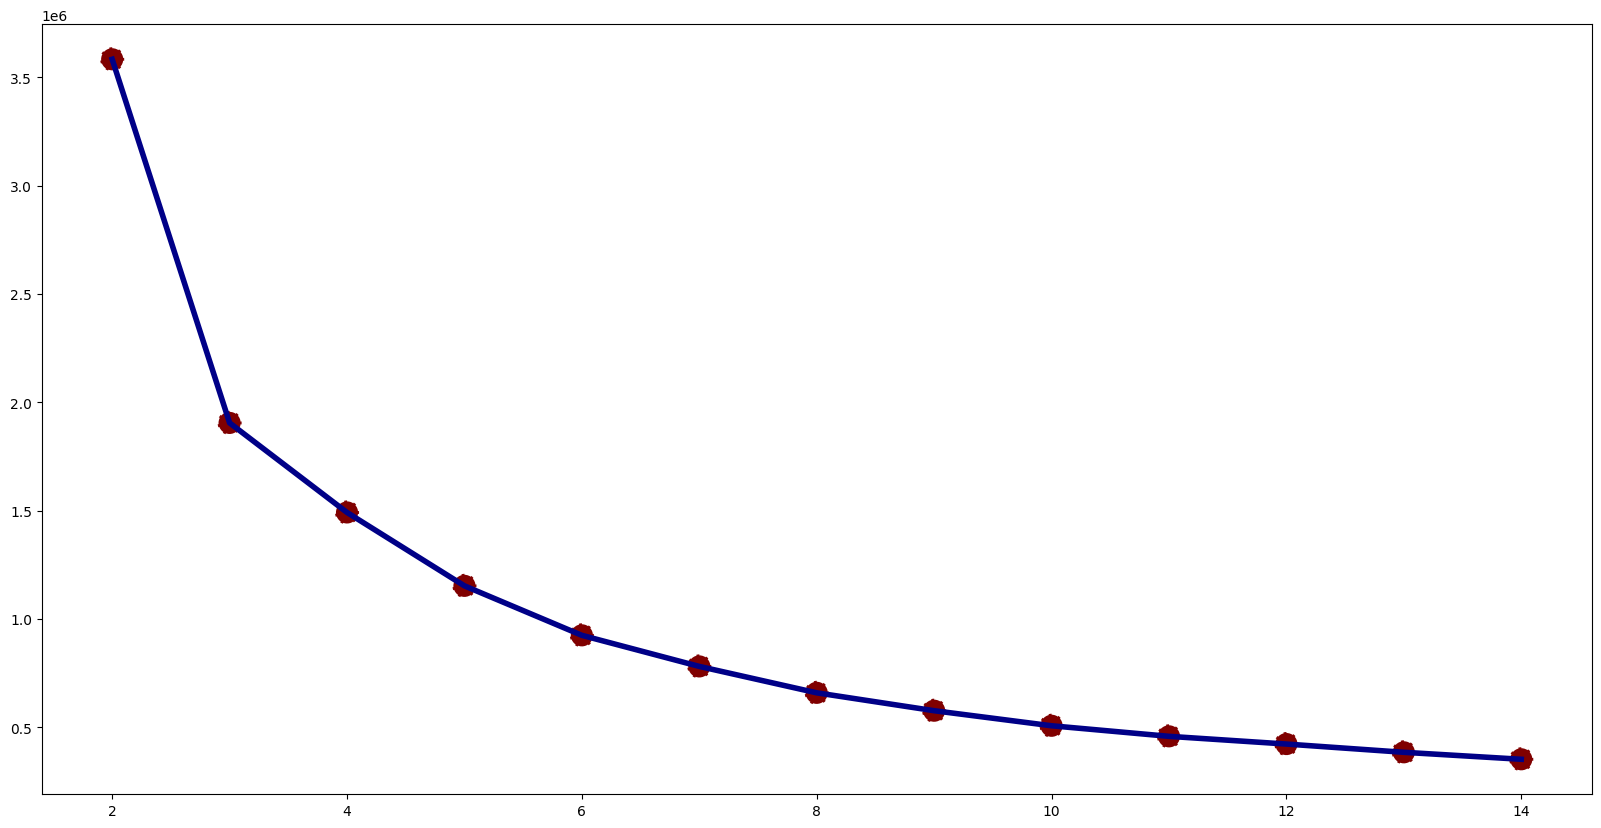

In [ ]:
from sklearn.cluster import KMeans
inertia = []

for i in range(2, 15):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(Xtsne)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(20, 10))

sns.lineplot(x=range(2, 15), y=inertia, color='#000087', linewidth = 4)
sns.scatterplot(x=range(2, 15), y=inertia, s=300, color='#800000',  linestyle='--')

#### Elbow

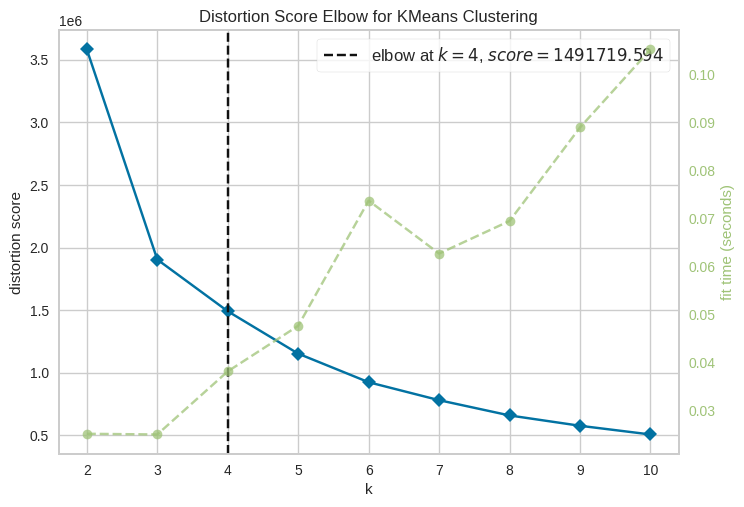

In [ ]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.cluster import KElbowVisualizer

Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(Xtsne)
Elbow_M.show()
plt.show()

#### silhouette score

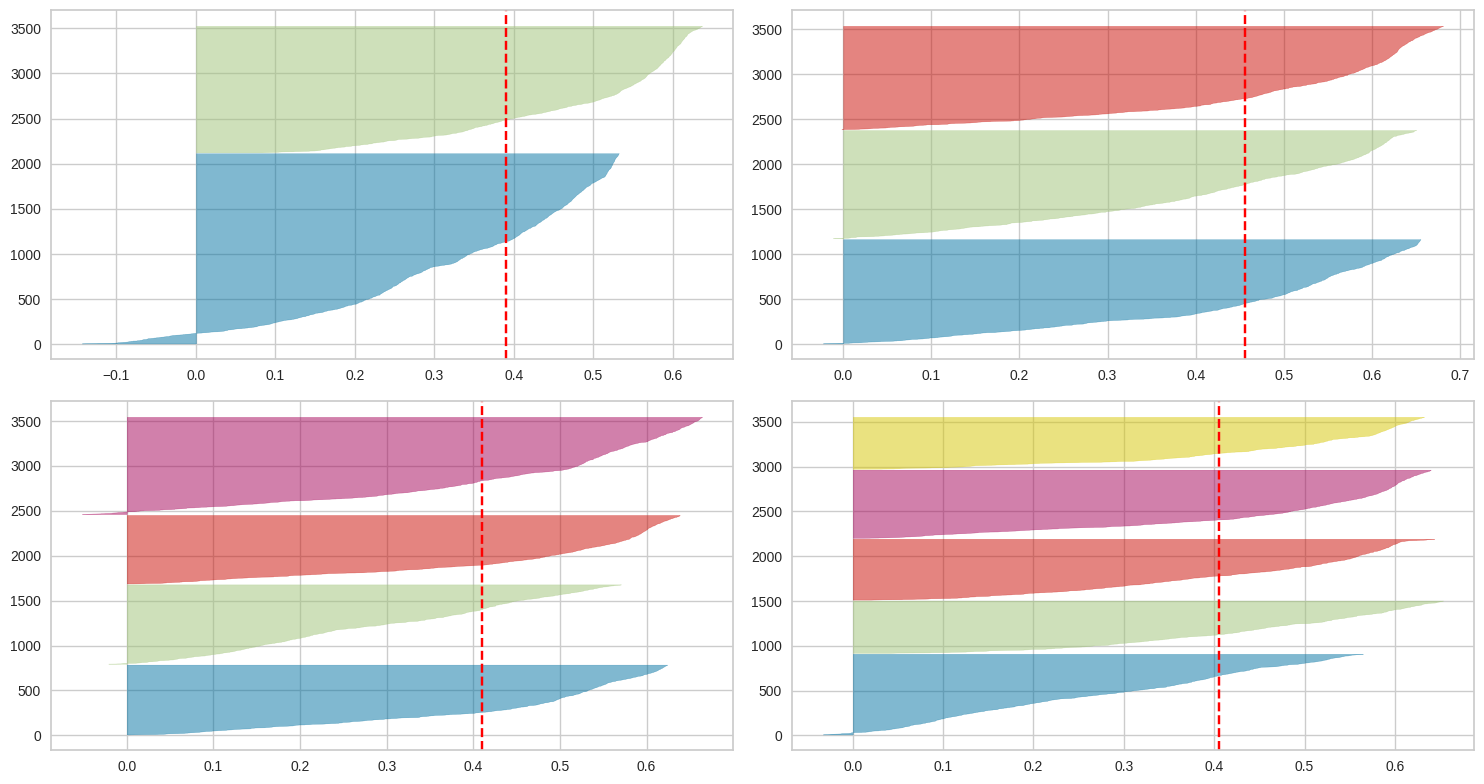

Skor siluet maksimum: 0.4556119
Jumlah cluster terbaik: 3


In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

n_clusters = [2, 3, 4, 5]  # Jumlah cluster yang ingin dievaluasi

fig, ax = plt.subplots(2, 2, figsize=(15, 8))

max_silhouette_score = float('-inf')
best_k = None

for i, k in enumerate(n_clusters):
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q][mod])
    visualizer.fit(Xtsne)
    
    # Mendapatkan label cluster
    labels = km.labels_
    
    # Menghitung skor siluet rata-rata
    silhouette_avg = silhouette_score(Xtsne, labels)
    
    # Memperbarui skor siluet maksimum dan jumlah cluster terbaik
    if silhouette_avg > max_silhouette_score:
        max_silhouette_score = silhouette_avg
        best_k = k

plt.tight_layout()
plt.show()

print("Skor siluet maksimum:", max_silhouette_score)
print("Jumlah cluster terbaik:", best_k)

### Clustering n = 4

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(Xtsne)

KMeans(n_clusters=4, random_state=0)

In [ ]:
dataset['clusters'] = kmeans.labels_
dftsne['clusters'] = kmeans.labels_
dataset.head()

,Recency,Frequency,Monetary,clusters
CustomerID,,,,
12348.0,76,31,1797.24,3
12349.0,19,73,1757.55,1
12350.0,311,17,334.40,0
12352.0,37,67,1405.28,1
12353.0,205,4,89.00,0


In [ ]:
perc = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
dataset.describe(percentiles=perc)

,Recency,Frequency,Monetary,clusters
count,3508.000000,3508.000000,3508.000000,3508.000000
mean,95.407355,48.169612,758.235400,1.416762
std,91.467008,44.817324,649.462792,1.168044
min,1.000000,1.000000,2.900000,0.000000
10%,10.000000,7.000000,145.881000,0.000000
20%,19.000000,12.000000,222.768000,0.000000
30%,29.000000,18.000000,314.727000,0.000000
40%,41.000000,25.000000,404.544000,1.000000
50%,60.000000,33.000000,546.300000,1.000000
60%,79.000000,44.000000,689.910000,2.000000


In [ ]:
dataset.groupby('clusters').agg({
                            'Recency' : ['mean'],
                            'Frequency' : ['mean'],
                            'Monetary' : ['mean','median']
    
})

Recency   Frequency     Monetary         
                mean        mean         mean   median
clusters                                              
0         214.948292   26.749769   444.526704   330.11
1          36.828309  113.378768  1640.366461  1682.77
2          50.525032   15.347882   295.371068   281.42
3          39.004530   47.049830   789.098178   773.03

In [ ]:
dataset.head(3)

,Recency,Frequency,Monetary,clusters
CustomerID,,,,
12348.0,76,31,1797.24,3
12349.0,19,73,1757.55,1
12350.0,311,17,334.40,0


#### Clustering Visualization

In [ ]:
dftsne.head(2)

,x1,x2,clusters
0,16.743134,13.198086,3
1,31.603968,19.764206,1


<Axes: xlabel='x1', ylabel='x2'>

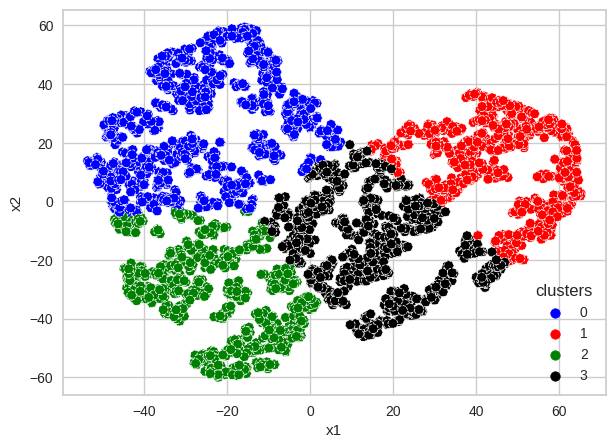

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))

sns.scatterplot(
    x="x1", y="x2",
    hue="clusters",
    palette=['blue','red','green','black','pink','orange'],
    linestyle='--',
    data=dftsne,
    ax=ax
)

#### Visualization in dataset RFM

In [ ]:
def visualize_eval(x,y,hue,data):
    fig, ax = plt.subplots(figsize=(7,5))

    sns.scatterplot(
        x=x, y=y,
        hue=hue,
        palette=['blue','red','green','black','pink','orange'],
        linestyle='--',
        data=data,
        ax=ax
    )
    plt.show()

In [ ]:
dataset.head()

,Recency,Frequency,Monetary,clusters
CustomerID,,,,
12348.0,76,31,1797.24,3
12349.0,19,73,1757.55,1
12350.0,311,17,334.40,0
12352.0,37,67,1405.28,1
12353.0,205,4,89.00,0


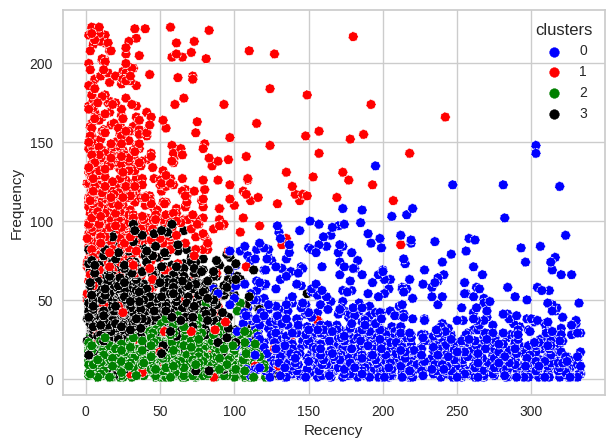

In [ ]:
visualize_eval('Recency','Frequency','clusters',dataset)

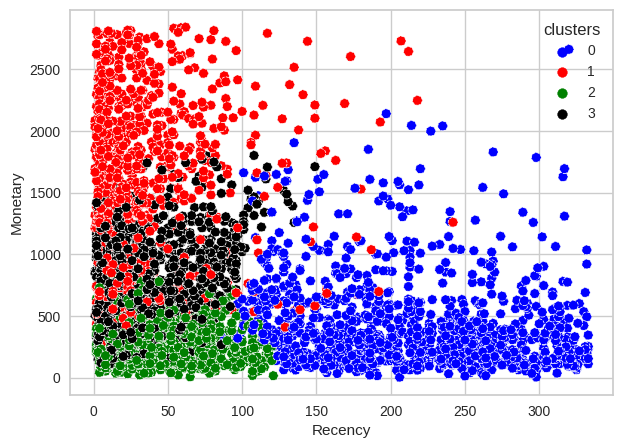

In [ ]:
visualize_eval('Recency','Monetary','clusters',dataset)

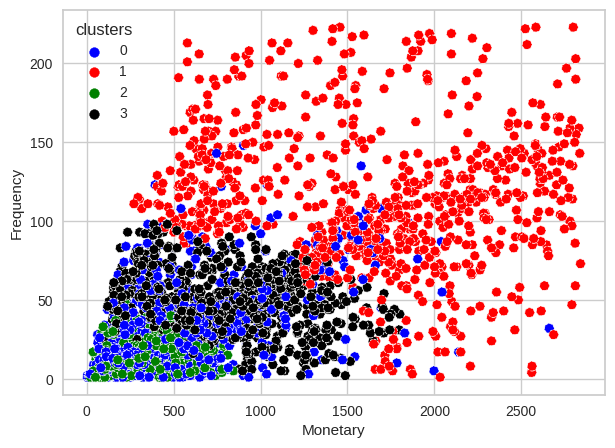

In [ ]:
visualize_eval('Monetary','Frequency','clusters',dataset)

### Clustering n = 3

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(Xtsne)

KMeans(n_clusters=3, random_state=0)

In [ ]:
dataset['clusters'] = kmeans.labels_
dftsne['clusters'] = kmeans.labels_
dataset.head()

,Recency,Frequency,Monetary,clusters
CustomerID,,,,
12348.0,76,31,1797.24,2
12349.0,19,73,1757.55,2
12350.0,311,17,334.40,1
12352.0,37,67,1405.28,2
12353.0,205,4,89.00,1


In [ ]:
perc = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
dataset.describe(percentiles=perc)

,Recency,Frequency,Monetary,clusters
count,3508.000000,3508.000000,3508.000000,3508.000000
mean,95.407355,48.169612,758.235400,0.986032
std,91.467008,44.817324,649.462792,0.818296
min,1.000000,1.000000,2.900000,0.000000
10%,10.000000,7.000000,145.881000,0.000000
20%,19.000000,12.000000,222.768000,0.000000
30%,29.000000,18.000000,314.727000,0.000000
40%,41.000000,25.000000,404.544000,1.000000
50%,60.000000,33.000000,546.300000,1.000000
60%,79.000000,44.000000,689.910000,1.000000


In [ ]:
dataset.groupby('clusters').agg({
                            'Recency' : ['mean'],
                            'Frequency' : ['mean'],
                            'Monetary' : ['mean','median']
    
})

Recency  Frequency     Monetary         
                mean       mean         mean   median
clusters                                             
0          43.417014  24.792327   414.428601   364.14
1         207.383952  27.106989   458.322442   333.74
2          36.760000  93.770435  1418.951461  1345.44

In [ ]:
dataset.head(3)

,Recency,Frequency,Monetary,clusters
CustomerID,,,,
12348.0,76,31,1797.24,2
12349.0,19,73,1757.55,2
12350.0,311,17,334.40,1


#### Clustering Visualization

In [ ]:
dftsne.head(2)

,x1,x2,clusters
0,16.743134,13.198086,2
1,31.603968,19.764206,2


<Axes: xlabel='x1', ylabel='x2'>

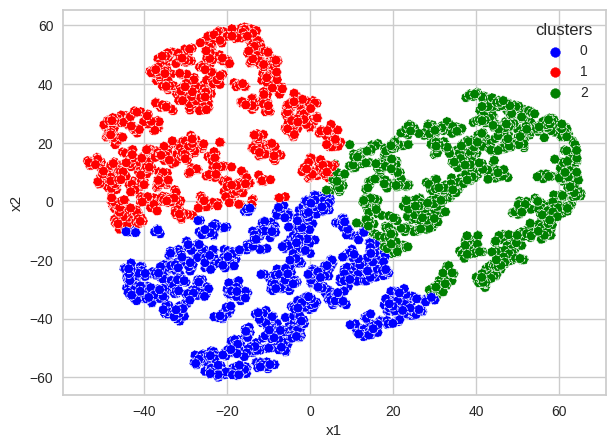

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))

sns.scatterplot(
    x="x1", y="x2",
    hue="clusters",
    palette=['blue','red','green','black','pink','orange'],
    linestyle='--',
    data=dftsne,
    ax=ax
)

#### Visualization in dataset RFM

In [ ]:
def visualize_eval(x,y,hue,data):
    fig, ax = plt.subplots(figsize=(7,5))

    sns.scatterplot(
        x=x, y=y,
        hue=hue,
        palette=['blue','red','green','black','pink','orange'],
        linestyle='--',
        data=data,
        ax=ax
    )
    plt.show()

In [ ]:
dataset.head()

,Recency,Frequency,Monetary,clusters
CustomerID,,,,
12348.0,76,31,1797.24,2
12349.0,19,73,1757.55,2
12350.0,311,17,334.40,1
12352.0,37,67,1405.28,2
12353.0,205,4,89.00,1


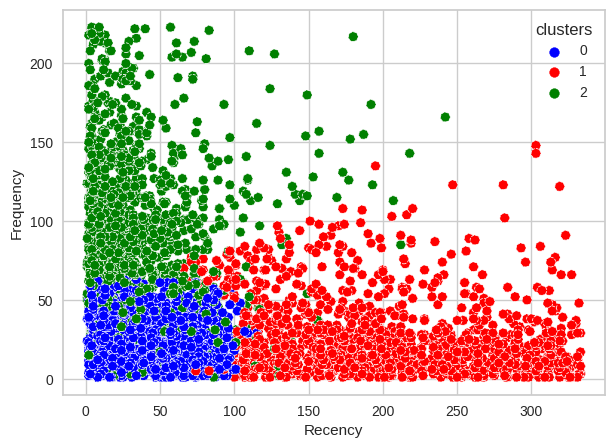

In [ ]:
visualize_eval('Recency','Frequency','clusters',dataset)

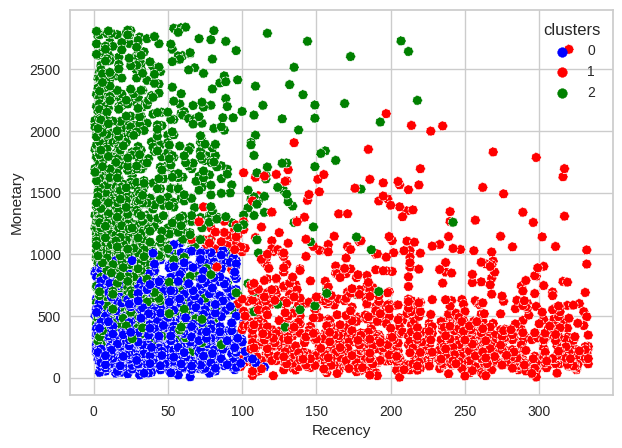

In [ ]:
visualize_eval('Recency','Monetary','clusters',dataset)

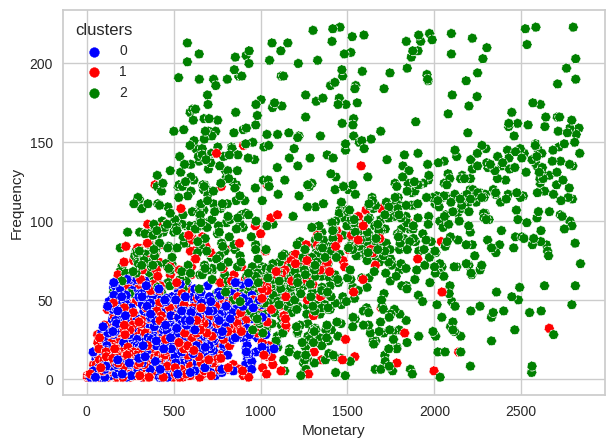

In [ ]:
visualize_eval('Monetary','Frequency','clusters',dataset)

### Clustering n = 3 lebih baik.

### Clustering Analysis n = 3

In [ ]:
dataset['aov'] = dataset['Monetary']/dataset['Frequency']

In [ ]:
dataset.groupby('clusters').agg({
    'Recency' : ['mean'],
    'Frequency' : ['mean'],
    'Monetary' : ['mean','median'],
    'aov' : ['mean']
    
    
})

Recency  Frequency     Monetary                 aov
                mean       mean         mean   median       mean
clusters                                                        
0          43.417014  24.792327   414.428601   364.14  24.847601
1         207.383952  27.106989   458.322442   333.74  31.177895
2          36.760000  93.770435  1418.951461  1345.44  26.325467

Observation:
* Cluster 0: New Customers

Rata-rata Recency: 43.42

Rata-rata Frequency: 24.79

Rata-rata Monetary: 414.43

Karakteristik: Pelanggan dalam kluster ini memiliki recency yang relatif baru, frekuensi pembelian yang rendah, dan nilai moneternya juga relatif rendah.

Penjelasan: Pelanggan dalam kluster ini mungkin belum lama melakukan pembelian (recency yang rendah), tetapi frekuensi pembelian mereka rendah dan nilai moneternya juga rendah. Mereka mungkin baru-baru ini menjadi pelanggan atau tidak aktif dalam melakukan pembelian. Perlu upaya untuk mendorong mereka agar lebih aktif.

* Cluster 1: About to Sleep or Hibernating

Rata-rata Recency: 207.38

Rata-rata Frequency: 27.11

Rata-rata Monetary: 458.32

Karakteristik: Pelanggan dalam kluster ini memiliki recency yang cukup lama, frekuensi pembelian yang sedang, dan nilai moneternya stabil atau sedang.

Penjelasan: Pelanggan dalam kluster ini memiliki recency yang cukup lama, tetapi mereka masih melakukan pembelian dengan frekuensi yang stabil atau sedang. Nilai moneternya juga stabil. Mereka dapat dianggap sebagai pelanggan yang loyal atau tetap aktif dalam melakukan pembelian.

* Cluster 2:Champions atau Potential Loyalists

Rata-rata Recency: 36.76

Rata-rata Frequency: 93.77

Rata-rata Monetary: 1418.95

Karakteristik: Pelanggan dalam kluster ini memiliki recency yang sangat baru, frekuensi pembelian yang tinggi, dan nilai moneternya sangat tinggi.

Penjelasan: Pelanggan dalam kluster ini memiliki recency yang sangat baru, frekuensi pembelian yang tinggi, dan nilai moneternya juga sangat tinggi. Mereka merupakan pelanggan dengan nilai tinggi yang secara teratur melakukan pembelian. Mereka bisa dianggap sebagai pelanggan andalan atau pelanggan potensial yang loyal.

### Cluster Distribution

In [ ]:
dataset.head()

,Recency,Frequency,Monetary,clusters,aov
CustomerID,,,,,
12348.0,76,31,1797.24,2,57.975484
12349.0,19,73,1757.55,2,24.076027
12350.0,311,17,334.40,1,19.670588
12352.0,37,67,1405.28,2,20.974328
12353.0,205,4,89.00,1,22.250000


In [ ]:
cluster_counts = dataset.groupby('clusters').size()
print(cluster_counts)

clusters
0    1199
1    1159
2    1150
dtype: int64


In [ ]:
dataset

,Recency,Frequency,Monetary,clusters,aov
CustomerID,,,,,
12348.0,76,31,1797.24,2,57.975484
12349.0,19,73,1757.55,2,24.076027
12350.0,311,17,334.40,1,19.670588
12352.0,37,67,1405.28,2,20.974328
12353.0,205,4,89.00,1,22.250000
...,...,...,...,...,...
18278.0,74,9,173.90,0,19.322222
18280.0,278,10,180.60,1,18.060000
18281.0,181,7,80.82,1,11.545714


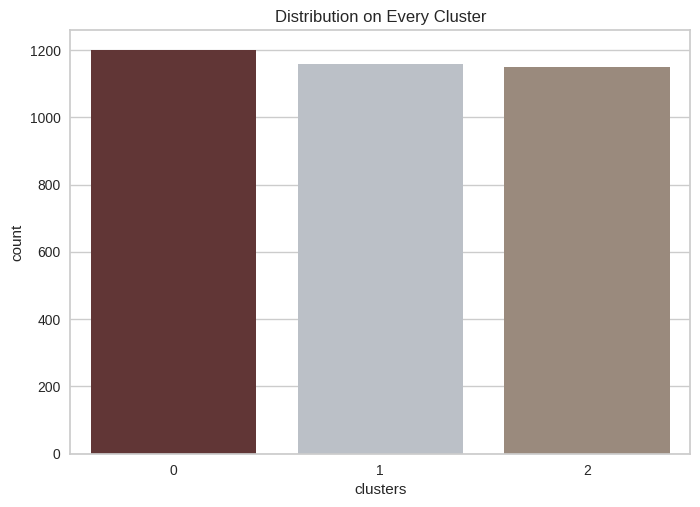

In [ ]:
pal = ["#682F2F","#B9C0C9", "#9F8A78"]
pl = sns.countplot(x = dataset['clusters'], palette= pal)
pl.set_title("Distribution on Every Cluster")
plt.show()

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDateDay,InvoiceDateTime,InvoiceYear,InvoiceMonth,InvoiceMonthName,InvoiceDay,InvoiceDayName,InvoiceDayOfWeek,InvoiceWeekOfYear,InvoiceHour,TotalValue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,2010,12,December,1,Wednesday,2,48,8,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,2010,12,December,1,Wednesday,2,48,8,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,2010,12,December,1,Wednesday,2,48,8,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,2010,12,December,1,Wednesday,2,48,8,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,2010,12,December,1,Wednesday,2,48,8,20.34


In [ ]:
dataset.reset_index(inplace=True)
dataset.head()

,CustomerID,Recency,Frequency,Monetary,clusters,aov
0,12348.0,76,31,1797.24,2,57.975484
1,12349.0,19,73,1757.55,2,24.076027
2,12350.0,311,17,334.40,1,19.670588
3,12352.0,37,67,1405.28,2,20.974328
4,12353.0,205,4,89.00,1,22.250000


In [ ]:
data_cluster = dataset[['CustomerID','clusters']]
data_cluster.head()

,CustomerID,clusters
0,12348.0,2
1,12349.0,2
2,12350.0,1
3,12352.0,2
4,12353.0,1


In [ ]:
df[df['CustomerID']==12348].head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDateDay,InvoiceDateTime,InvoiceYear,InvoiceMonth,InvoiceMonthName,InvoiceDay,InvoiceDayName,InvoiceDayOfWeek,InvoiceWeekOfYear,InvoiceHour,TotalValue
34083,539318,84992,72 SWEETHEART FAIRY CAKE CASES,72,2010-12-16 19:09:00,0.55,12348.0,Finland,2010-12-16,19:09:00,2010,12,December,16,Thursday,3,50,19,39.6
34084,539318,22951,60 CAKE CASES DOLLY GIRL DESIGN,72,2010-12-16 19:09:00,0.55,12348.0,Finland,2010-12-16,19:09:00,2010,12,December,16,Thursday,3,50,19,39.6
34085,539318,84991,60 TEATIME FAIRY CAKE CASES,24,2010-12-16 19:09:00,0.55,12348.0,Finland,2010-12-16,19:09:00,2010,12,December,16,Thursday,3,50,19,13.2


### Merge dataset

In [ ]:
result_cluster_elbow = pd.merge(df, data_cluster, on="CustomerID")
result_cluster_elbow.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDateDay,InvoiceDateTime,InvoiceYear,InvoiceMonth,InvoiceMonthName,InvoiceDay,InvoiceDayName,InvoiceDayOfWeek,InvoiceWeekOfYear,InvoiceHour,TotalValue,clusters
0,536371,22086,PAPER CHAIN KIT 50'S CHRISTMAS,80,2010-12-01 09:00:00,2.55,13748.0,United Kingdom,2010-12-01,09:00:00,2010,12,December,1,Wednesday,2,48,9,204.0,0
1,549190,22843,BISCUIT TIN VINTAGE GREEN,2,2011-04-07 10:13:00,6.75,13748.0,United Kingdom,2011-04-07,10:13:00,2011,4,April,7,Thursday,3,14,10,13.5,0
2,549190,22841,ROUND CAKE TIN VINTAGE GREEN,2,2011-04-07 10:13:00,7.95,13748.0,United Kingdom,2011-04-07,10:13:00,2011,4,April,7,Thursday,3,14,10,15.9,0
3,549190,22839,3 TIER CAKE TIN GREEN AND CREAM,2,2011-04-07 10:13:00,14.95,13748.0,United Kingdom,2011-04-07,10:13:00,2011,4,April,7,Thursday,3,14,10,29.9,0
4,549190,22423,REGENCY CAKESTAND 3 TIER,2,2011-04-07 10:13:00,12.75,13748.0,United Kingdom,2011-04-07,10:13:00,2011,4,April,7,Thursday,3,14,10,25.5,0


In [ ]:
result_cluster_elbow.isna().sum()

InvoiceNo            0
StockCode            0
Description          0
Quantity             0
InvoiceDate          0
UnitPrice            0
CustomerID           0
Country              0
InvoiceDateDay       0
InvoiceDateTime      0
InvoiceYear          0
InvoiceMonth         0
InvoiceMonthName     0
InvoiceDay           0
InvoiceDayName       0
InvoiceDayOfWeek     0
InvoiceWeekOfYear    0
InvoiceHour          0
TotalValue           0
clusters             0
dtype: int64

## EDA Clustering Elbow = 3

In [ ]:
elbow_cls0 = result_cluster_elbow[result_cluster_elbow['clusters'] == 0]
elbow_cls1 = result_cluster_elbow[result_cluster_elbow['clusters'] == 1]
elbow_cls2 = result_cluster_elbow[result_cluster_elbow['clusters'] == 2]

In [ ]:
elbow_cls0.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDateDay,InvoiceDateTime,InvoiceYear,InvoiceMonth,InvoiceMonthName,InvoiceDay,InvoiceDayName,InvoiceDayOfWeek,InvoiceWeekOfYear,InvoiceHour,TotalValue,clusters
0,536371,22086,PAPER CHAIN KIT 50'S CHRISTMAS,80,2010-12-01 09:00:00,2.55,13748.0,United Kingdom,2010-12-01,09:00:00,2010,12,December,1,Wednesday,2,48,9,204.0,0


In [ ]:
elbow_cls1.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDateDay,InvoiceDateTime,InvoiceYear,InvoiceMonth,InvoiceMonthName,InvoiceDay,InvoiceDayName,InvoiceDayOfWeek,InvoiceWeekOfYear,InvoiceHour,TotalValue,clusters
125,536388,21754,HOME BUILDING BLOCK WORD,3,2010-12-01 09:59:00,5.95,16250.0,United Kingdom,2010-12-01,09:59:00,2010,12,December,1,Wednesday,2,48,9,17.85,1


In [ ]:
elbow_cls2.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDateDay,InvoiceDateTime,InvoiceYear,InvoiceMonth,InvoiceMonthName,InvoiceDay,InvoiceDayName,InvoiceDayOfWeek,InvoiceWeekOfYear,InvoiceHour,TotalValue,clusters
28,536382,10002,INFLATABLE POLITICAL GLOBE,12,2010-12-01 09:45:00,0.85,16098.0,United Kingdom,2010-12-01,09:45:00,2010,12,December,1,Wednesday,2,48,9,10.2,2


#### End Customer - Country

In [ ]:
country_counts = result_cluster_elbow.groupby(['clusters', 'Country']).size().reset_index(name='sum_of_country')
country_counts

,clusters,Country,sum_of_country
0,0,Australia,70
1,0,Austria,33
2,0,Belgium,119
3,0,Cyprus,29
4,0,Czech Republic,23
...,...,...,...
69,2,Sweden,155
70,2,Switzerland,206
71,2,USA,45
72,2,United Kingdom,100211


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_top_countries(country_counts, cluster_count=3, top_n=5):
    fig, ax = plt.subplots(cluster_count, 1, figsize=(10, 8))

    for cluster in range(cluster_count):
        top_countries = country_counts[country_counts['clusters'] == cluster].nlargest(top_n, 'sum_of_country')

        sns.barplot(x='Country', y='sum_of_country', data=top_countries, ax=ax[cluster])
        ax[cluster].set_title(f'Top {top_n} Countries in Cluster {cluster}')

    plt.tight_layout()
    plt.show()


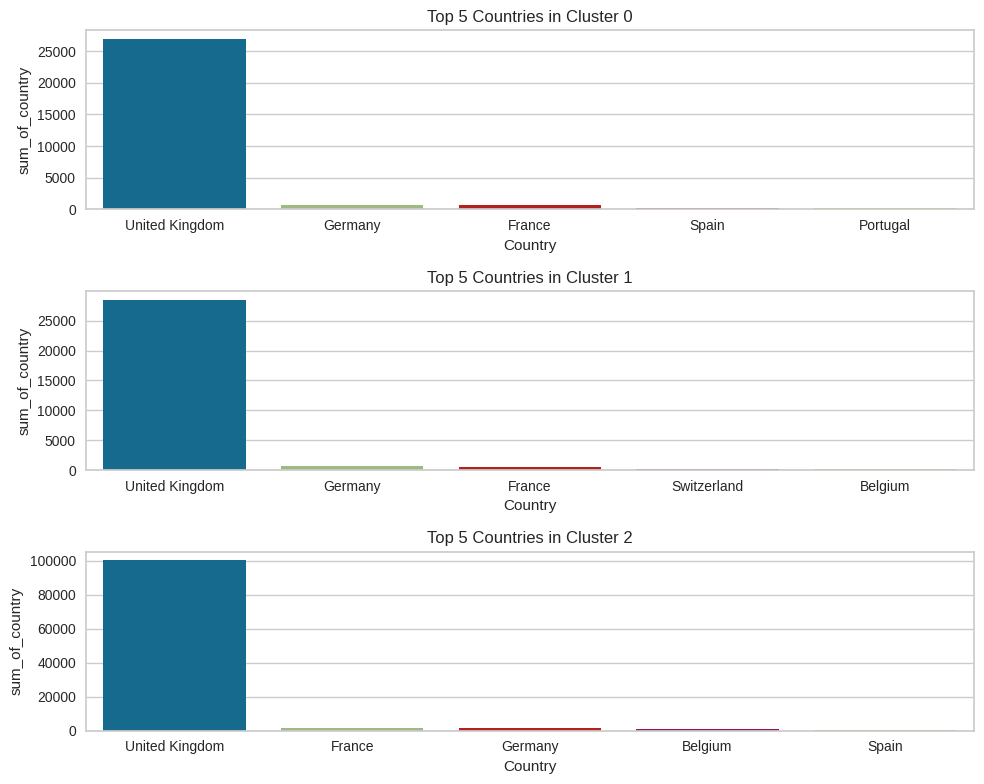

In [ ]:
plot_top_countries(country_counts, cluster_count=3, top_n=5)

#### END Customer - Product

In [ ]:
top_products = result_cluster_elbow.groupby(['clusters', 'Description']).size().reset_index(name='count')
top_products

,clusters,Description,count
0,0,4 PURPLE FLOCK DINNER CANDLES,7
1,0,50'S CHRISTMAS GIFT BAG LARGE,15
2,0,DOLLY GIRL BEAKER,6
3,0,I LOVE LONDON MINI BACKPACK,13
4,0,NINE DRAWER OFFICE TIDY,4
...,...,...,...
9270,2,ZINC T-LIGHT HOLDER STARS SMALL,72
9271,2,ZINC TOP 2 DOOR WOODEN SHELF,1
9272,2,ZINC WILLIE WINKIE CANDLE STICK,61
9273,2,ZINC WIRE KITCHEN ORGANISER,2


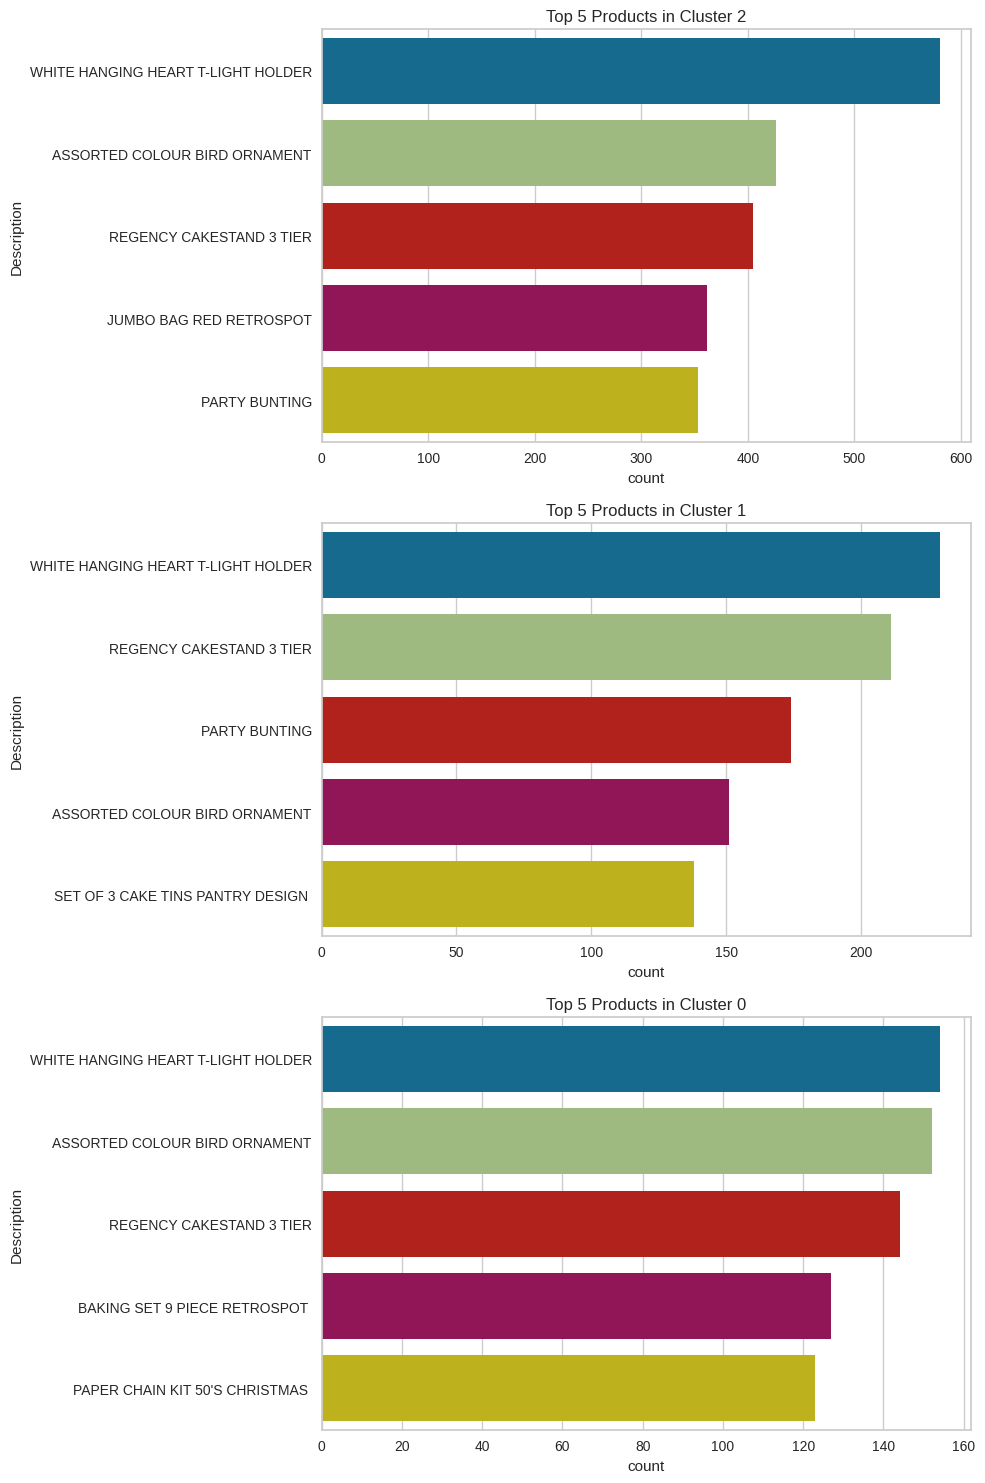

In [ ]:
top_products_sorted = top_products.sort_values(['clusters', 'count'], ascending=False).groupby('clusters').head(5)

fig, ax = plt.subplots(len(top_products_sorted['clusters'].unique()), 1, figsize=(10, 15))

for i, cluster in enumerate(top_products_sorted['clusters'].unique()):
    cluster_data = top_products_sorted[top_products_sorted['clusters'] == cluster]
    sns.barplot(x='count', y='Description', data=cluster_data, ax=ax[i])
    ax[i].set_title(f'Top 5 Products in Cluster {cluster}')

plt.tight_layout()
plt.show()

#### End Customer - Day

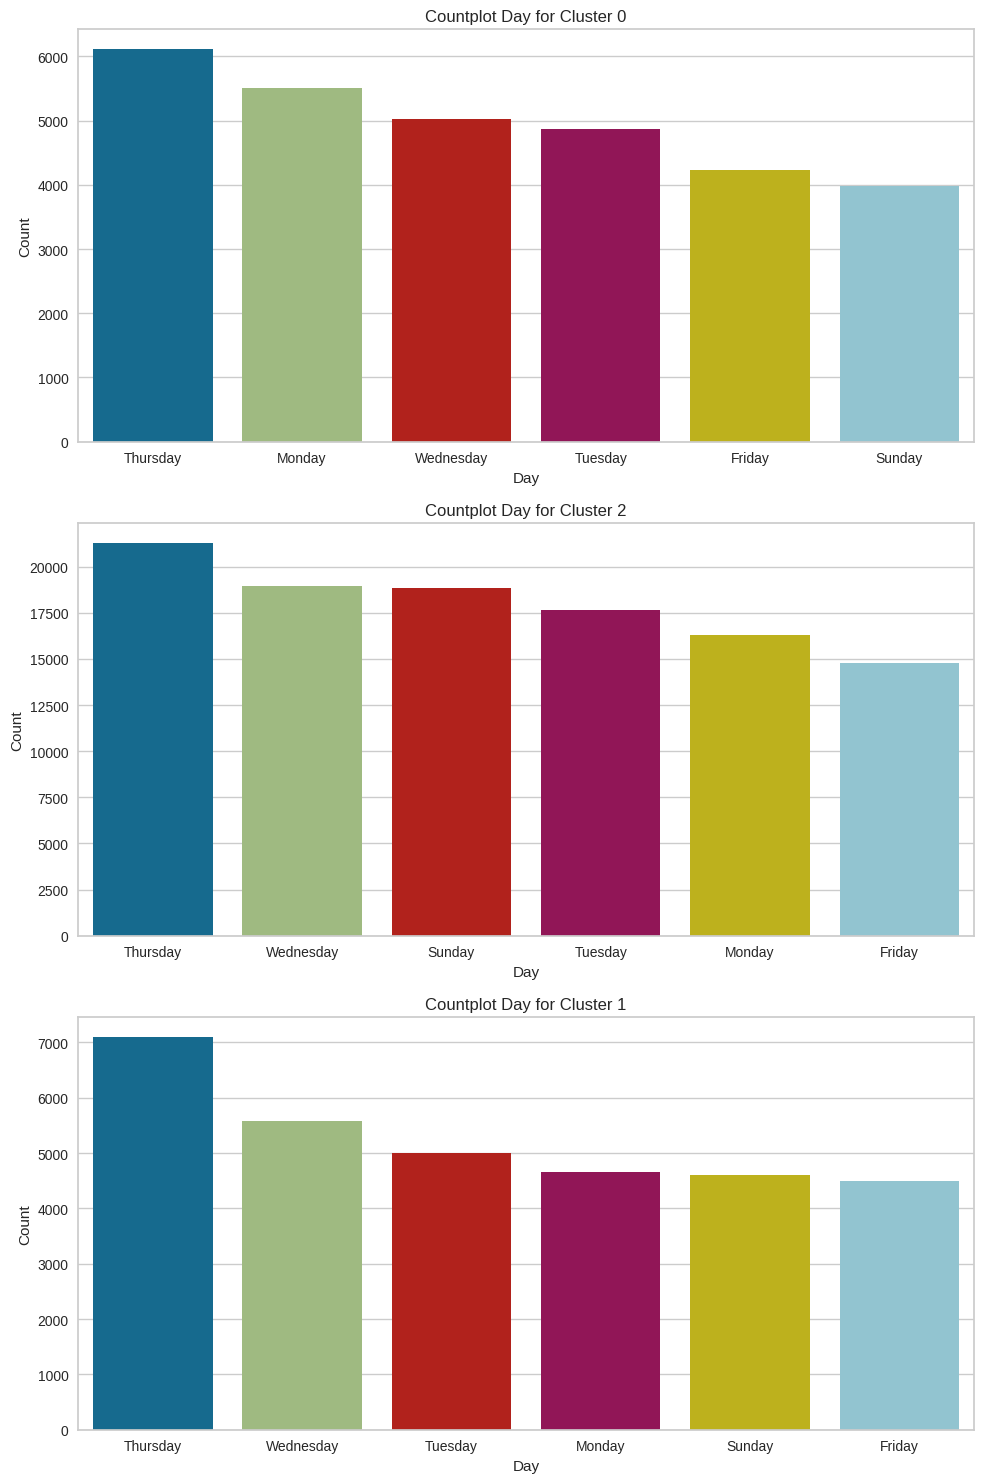

In [ ]:
def plot_countplot_by_cluster(data, cluster_column, day_column):
    unique_clusters = data[cluster_column].unique()

    fig, ax = plt.subplots(len(unique_clusters), 1, figsize=(10, 15))

    for i, cluster in enumerate(unique_clusters):
        cluster_data = data[data[cluster_column] == cluster]
        order = cluster_data[day_column].value_counts().index

        sns.countplot(x=day_column, data=cluster_data, order=order, ax=ax[i])
        ax[i].set_title(f'Countplot Day for Cluster {cluster}')
        ax[i].set_xlabel('Day')
        ax[i].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

# Memanggil fungsi plot_countplot_by_cluster
plot_countplot_by_cluster(result_cluster_elbow, 'clusters', 'InvoiceDayName')

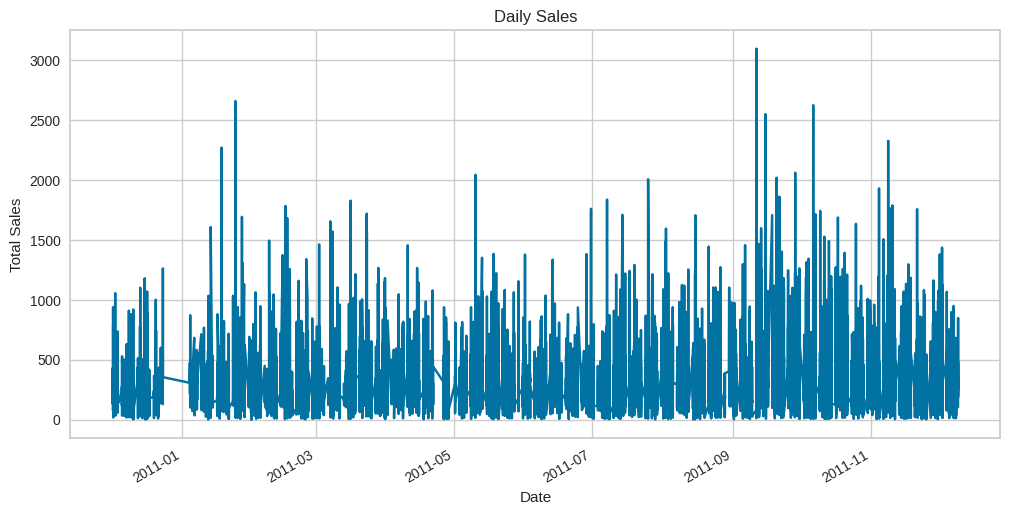

In [ ]:
# Visualisasi tren penjualan harian
daily_sales = result_cluster_elbow.groupby('InvoiceDate').sum()['TotalValue']
plt.figure(figsize=(12, 6))
daily_sales.plot()
plt.title('Daily Sales')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

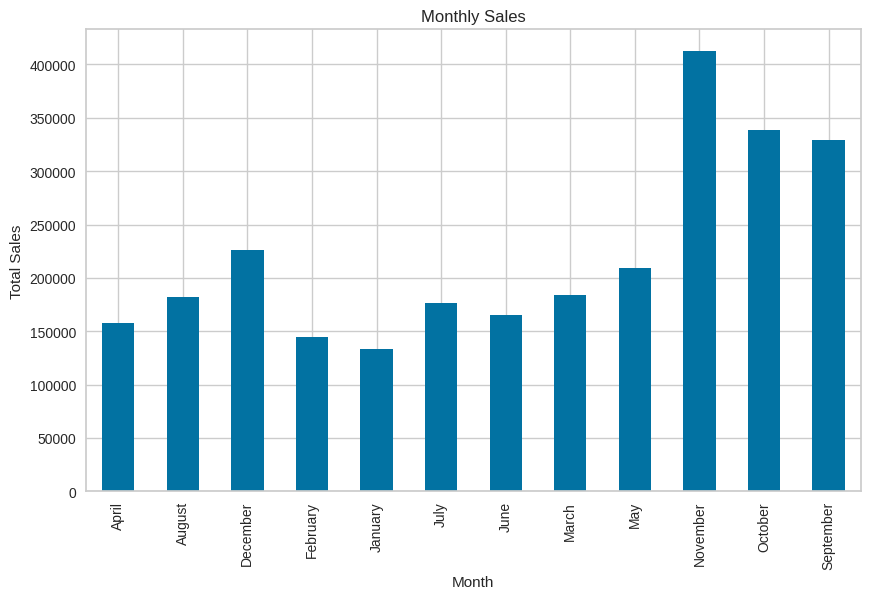

In [ ]:
# Visualisasi penjualan berdasarkan bulan
monthly_sales = result_cluster_elbow.groupby('InvoiceMonthName').sum()['TotalValue']
plt.figure(figsize=(10, 6))
monthly_sales.plot(kind='bar')
plt.title('Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()

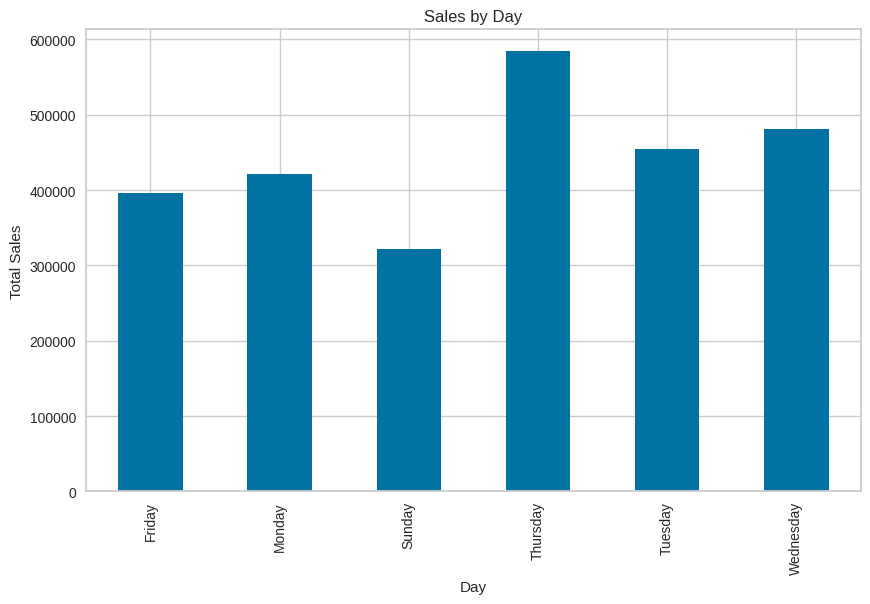

In [ ]:
# Visualisasi penjualan berdasarkan hari
day_sales = result_cluster_elbow.groupby('InvoiceDayName').sum()['TotalValue']
plt.figure(figsize=(10, 6))
day_sales.plot(kind='bar')
plt.title('Sales by Day')
plt.xlabel('Day')
plt.ylabel('Total Sales')
plt.show()

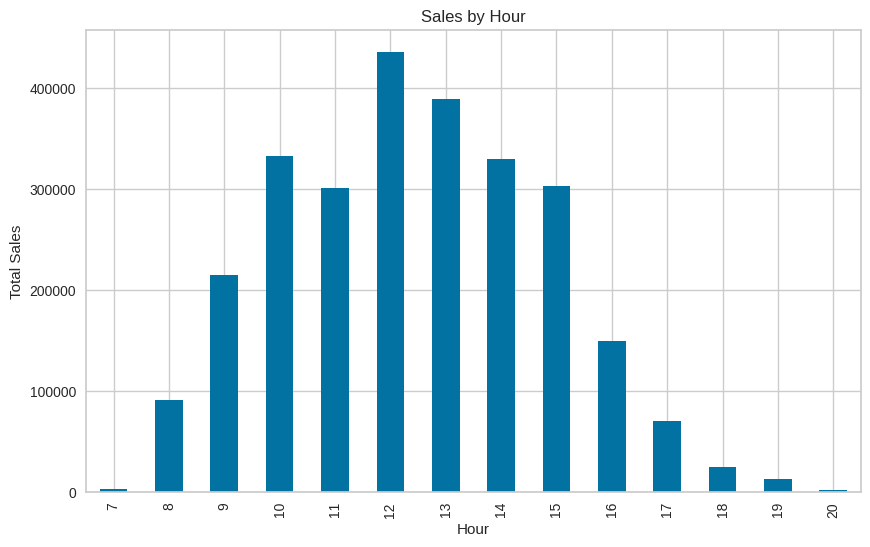

In [ ]:
# Visualisasi penjualan berdasarkan jam
hour_sales = result_cluster_elbow.groupby('InvoiceHour').sum()['TotalValue']
plt.figure(figsize=(10, 6))
hour_sales.plot(kind='bar')
plt.title('Sales by Hour')
plt.xlabel('Hour')
plt.ylabel('Total Sales')
plt.show()

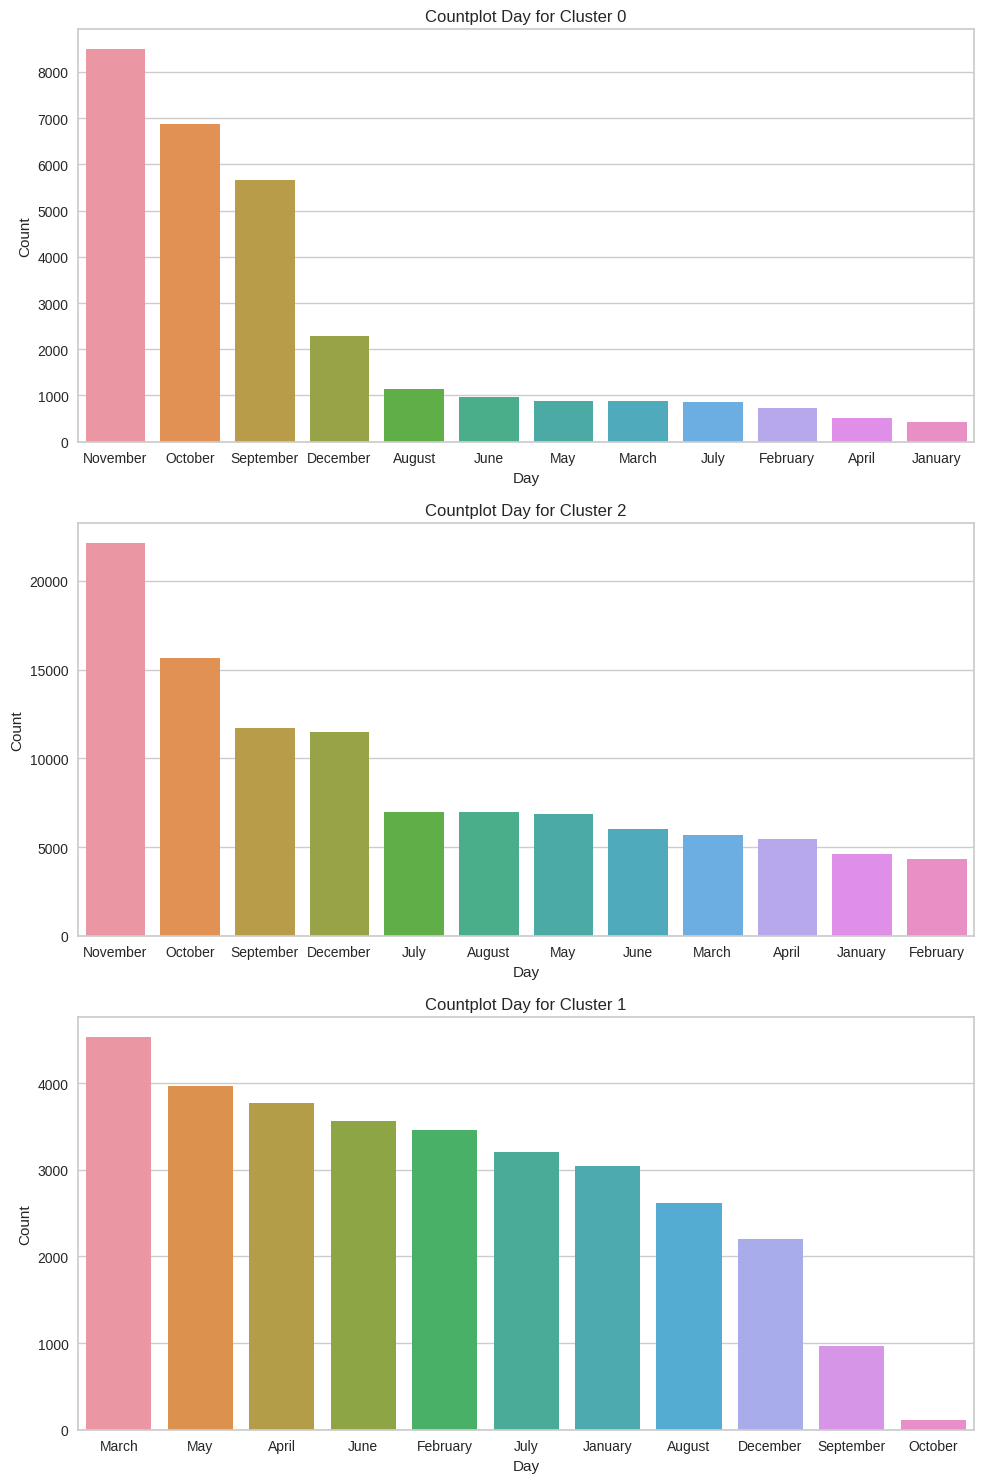

In [ ]:
def plot_countplot_by_cluster(data, cluster_column, day_column):
    unique_clusters = data[cluster_column].unique()

    fig, ax = plt.subplots(len(unique_clusters), 1, figsize=(10, 15))

    for i, cluster in enumerate(unique_clusters):
        cluster_data = data[data[cluster_column] == cluster]
        order = cluster_data[day_column].value_counts().index

        sns.countplot(x=day_column, data=cluster_data, order=order, ax=ax[i])
        ax[i].set_title(f'Countplot Day for Cluster {cluster}')
        ax[i].set_xlabel('Day')
        ax[i].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

# Memanggil fungsi plot_countplot_by_cluster
plot_countplot_by_cluster(result_cluster_elbow, 'clusters', 'InvoiceMonthName')